# OpenVINO example with Squeezenet Model 

This notebook illustrates how you can serve [OpenVINO](https://software.intel.com/en-us/openvino-toolkit) optimized models for Imagenet with Seldon Core.

<img src="dog.jpeg"/>

## Run Seldon Core on Minikube

**The example below assumes Minikube 0.30.0 installed**

It also assumes;
  * You have 4G of memory available
  * You have 4 CPU Cores available
  * You have 20G of free disk

In [2]:
!minikube start --memory 4096 --cpus 4 --disk-size 20g

Starting local Kubernetes v1.13.2 cluster...
Starting VM...
Getting VM IP address...
Moving files into cluster...
Setting up certs...
Connecting to cluster...
Setting up kubeconfig...
Stopping extra container runtimes...
Starting cluster components...
Verifying kubelet health ...
Verifying apiserver health ...
Kubectl is now configured to use the cluster.
Loading cached images from config file.


Everything looks great. Please enjoy minikube!


In [3]:
!kubectl create namespace seldon

namespace/seldon created


In [4]:
!kubectl config set-context $(kubectl config current-context) --namespace=seldon

Context "minikube" modified.


In [5]:
!kubectl create clusterrolebinding kube-system-cluster-admin --clusterrole=cluster-admin --serviceaccount=kube-system:default

clusterrolebinding.rbac.authorization.k8s.io/kube-system-cluster-admin created


In [6]:
!helm init

$HELM_HOME has been configured at /home/clive/.helm.

Tiller (the Helm server-side component) has been installed into your Kubernetes Cluster.

Please note: by default, Tiller is deployed with an insecure 'allow unauthenticated users' policy.
To prevent this, run `helm init` with the --tiller-tls-verify flag.
For more information on securing your installation see: https://docs.helm.sh/using_helm/#securing-your-helm-installation
Happy Helming!


In [7]:
!kubectl rollout status deploy/tiller-deploy -n kube-system

Waiting for deployment spec update to be observed...
Waiting for deployment spec update to be observed...
Waiting for deployment "tiller-deploy" rollout to finish: 0 out of 1 new replicas have been updated...
Waiting for deployment "tiller-deploy" rollout to finish: 0 of 1 updated replicas are available...
deployment "tiller-deploy" successfully rolled out


In [8]:
!helm install ../../../helm-charts/seldon-core-crd --name seldon-core-crd  --set usage_metrics.enabled=true
!helm install ../../../helm-charts/seldon-core --name seldon-core --set ambassador.enabled=true

NAME:   seldon-core-crd
LAST DEPLOYED: Mon Feb 11 16:58:00 2019
NAMESPACE: seldon
STATUS: DEPLOYED

RESOURCES:
==> v1/ServiceAccount
NAME                        SECRETS  AGE
seldon-spartakus-volunteer  1        0s

==> v1beta1/ClusterRole
NAME                        AGE
seldon-spartakus-volunteer  0s

==> v1beta1/ClusterRoleBinding
NAME                        AGE
seldon-spartakus-volunteer  0s

==> v1/ConfigMap
NAME                     DATA  AGE
seldon-spartakus-config  3     4s

==> v1beta1/CustomResourceDefinition
NAME                                         AGE
seldondeployments.machinelearning.seldon.io  0s

==> v1beta1/Deployment
NAME                        DESIRED  CURRENT  UP-TO-DATE  AVAILABLE  AGE
seldon-spartakus-volunteer  1        0        0           0          0s


NOTES:
NOTES: TODO


NAME:   seldon-core
LAST DEPLOYED: Mon Feb 11 16:58:05 2019
NAMESPACE: seldon
STATUS: DEPLOYED

RESOURCES:
==> v1/ServiceAccount
NAME    SECRETS  AGE
seldon  1        0s

==> v1/Role
NAME  

## (Optional) Install Jaeger

We will use the Jaeger All-in-1 resource found at the [Jaeger Kubernetes repo](https://github.com/jaegertracing/jaeger-kubernetes).

In [9]:
!kubectl create -f https://raw.githubusercontent.com/jaegertracing/jaeger-kubernetes/master/all-in-one/jaeger-all-in-one-template.yml -n seldon

deployment.extensions/jaeger-deployment created
service/jaeger-query created
service/jaeger-collector created
service/jaeger-agent created
service/zipkin created


### Start Jaeger UI

```
minikube service jaeger-query -n seldon
```

## Build Model, Combiner and Transformer Images

In [10]:
%env REGISTRY=docker.io/seldonio

env: REGISTRY=docker.io/seldonio


In [18]:
!eval $(minikube docker-env) && cd resources/model && s2i build -E environment_grpc . ${REGISTRY}/seldon-core-s2i-openvino:0.1 ${REGISTRY}/openvino-demo-prediction:0.1

---> Installing application source...
---> Installing dependencies ...
Looking in links: /whl
  Url '/whl' is ignored. It is either a non-existing path or lacks a specific scheme.
  Url '/whl' is ignored. It is either a non-existing path or lacks a specific scheme.
  Url '/whl' is ignored. It is either a non-existing path or lacks a specific scheme.
  Url '/whl' is ignored. It is either a non-existing path or lacks a specific scheme.
  Url '/whl' is ignored. It is either a non-existing path or lacks a specific scheme.
  Url '/whl' is ignored. It is either a non-existing path or lacks a specific scheme.
  Url '/whl' is ignored. It is either a non-existing path or lacks a specific scheme.
  Url '/whl' is ignored. It is either a non-existing path or lacks a specific scheme.
  Url '/whl' is ignored. It is either a non-existing path or lacks a specific scheme.
  Url '/whl' is ignored. It is either a non-existing path or lacks a specific scheme.
  Url '/whl' is ignored. It is either a non-ex

Successfully built googleapis-common-protos
You are using pip version 10.0.1, however version 19.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
Build completed successfully


In [11]:
!eval $(minikube docker-env) && cd resources/combiner && s2i build -E environment_grpc . ${REGISTRY}/seldon-core-s2i-openvino:0.1 ${REGISTRY}/openvino-demo-combiner:0.1

---> Installing application source...
Build completed successfully


In [12]:
!eval $(minikube docker-env) && cd resources/transformer && s2i build -E environment_grpc . ${REGISTRY}/seldon-core-s2i-openvino:0.1 ${REGISTRY}/openvino-demo-transformer:0.1

---> Installing application source...
---> Installing dependencies ...
Looking in links: /whl
You are using pip version 10.0.1, however version 19.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
Build completed successfully


## Deploy Seldon Intel OpenVINO Graph 

 * Ingest compressed JPEG binary and transform to TensorFlow Proto payload
 * ensemble two OpenVINO optimized models for ImageNet: ResNet, DenseNet
 * Return result in human readable text



In [12]:
import sys
sys.path.append("../../../notebooks")
from visualizer import *

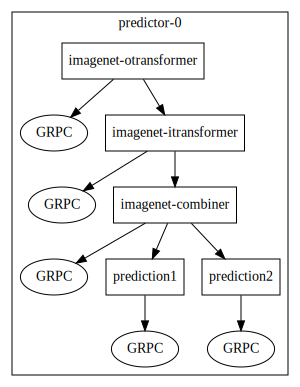

In [13]:
get_graph("seldon_ov_predict_ensemble.json")

In [14]:
!pygmentize seldon_ov_predict_ensemble.json

{
  "apiVersion": "machinelearning.seldon.io/v1alpha2",
  "kind": "SeldonDeployment",
  "metadata": {
    "labels": {
      "app": "seldon"
    },
    "name": "openvino-model",
    "namespace": "seldon"
  },
  "spec": {
    "name": "openvino",
    "predictors": [
      {
        "componentSpecs": [{
          "spec": {
            "containers": [
              {
                "name": "imagenet-itransformer",
                "image": "seldonio/openvino-demo-transformer:0.1",
                "env": [
                  {
                    "name": "TRACING",
                    "value": "1"
                  },
                  {
                    "name": "JAEGER_AGENT_HOST",
                    "value": "jaeger-agent"
                  }
                ]
              },
              {
                "name": "imagenet-otransformer",
                "image": "seldonio/openvino-demo-transformer:0.1",
                "env": [
                  {
                    "name": "TRACING

In [16]:
!kubectl apply -f seldon_ov_predict_ensemble.json

seldondeployment.machinelearning.seldon.io/openvino-model created


## Testing the pipeline

Expose ambassador API endpoint outside of the Kubernetes cluster or connect to it via `kubectl port-forward`.

```
kubectl port-forward $(kubectl get pods -n seldon -l service=ambassador -o jsonpath='{.items[0].metadata.name}') -n seldon 8080:8080
```

Install python dependencies:

In [17]:
!pip install seldon-core grpcio

You are using pip version 18.1, however version 19.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


Optionally expand `input_images.txt` to include bigger of a complete imagenet dataset in the same format: path to the image separated by the imagenet class number.

In [18]:
!python seldon_grpc_client.py --debug

meta {
  puid: "gktlsiknpmone6842lqnahhuul"
  routing {
    key: "imagenet-combiner"
    value: -1
  }
  routing {
    key: "imagenet-itransformer"
    value: -1
  }
  routing {
    key: "imagenet-otransformer"
    value: -1
  }
  requestPath {
    key: "imagenet-combiner"
    value: "seldonio/openvino-demo-combiner:0.1"
  }
  requestPath {
    key: "imagenet-itransformer"
    value: "seldonio/openvino-demo-transformer:0.1"
  }
  requestPath {
    key: "imagenet-otransformer"
    value: "seldonio/openvino-demo-transformer:0.1"
  }
  requestPath {
    key: "prediction1"
    value: "seldonio/openvino-demo-prediction:0.1"
  }
  requestPath {
    key: "prediction2"
    value: "seldonio/openvino-demo-prediction:0.1"
  }
}
strData: "Eskimo dog, husky"

Duration 1002.468
meta {
  puid: "ldm24c86jodkpelv36bf6j8305"
  routing {
    key: "imagenet-combiner"
    value: -1
  }
  routing {
    key: "imagenet-itransformer"
    value: -1
  }
  routing {
    key: "imagenet-otransformer"
    value: -1


For more extensive test see the client help:

In [28]:
!python seldon_grpc_client.py --help

usage: seldon_grpc_client.py [-h] [--repeats REPEATS] [--debug]
                             [--test-input TEST_INPUT]

optional arguments:
  -h, --help            show this help message and exit
  --repeats REPEATS
  --debug
  --test-input TEST_INPUT
